# Financial News and Stock Price Integration Dataset EDA



# Import Required Libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from datetime import datetime
from gensim import corpora, models

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chalie.lijalem\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.



# Load Dataset


In [4]:
df = pd.read_csv('../data/raw_analyst_ratings.csv')  
df.head()


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [6]:
# Check for missing values
df.isnull().sum()

# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')



In [7]:

# Headline length statistics
df['headline_length'] = df['headline'].astype(str).apply(len)
print(df['headline_length'].describe())


count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


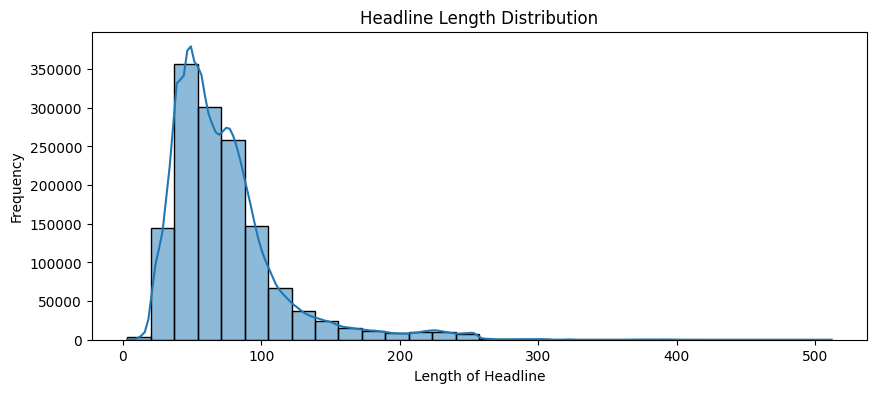

In [8]:

# Histogram of headline lengths
plt.figure(figsize=(10, 4))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title("Headline Length Distribution")
plt.xlabel("Length of Headline")
plt.ylabel("Frequency")
plt.show()


C:\Users\chalie.lijalem\AppData\Local\Temp\ipykernel_8972\582222513.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis')


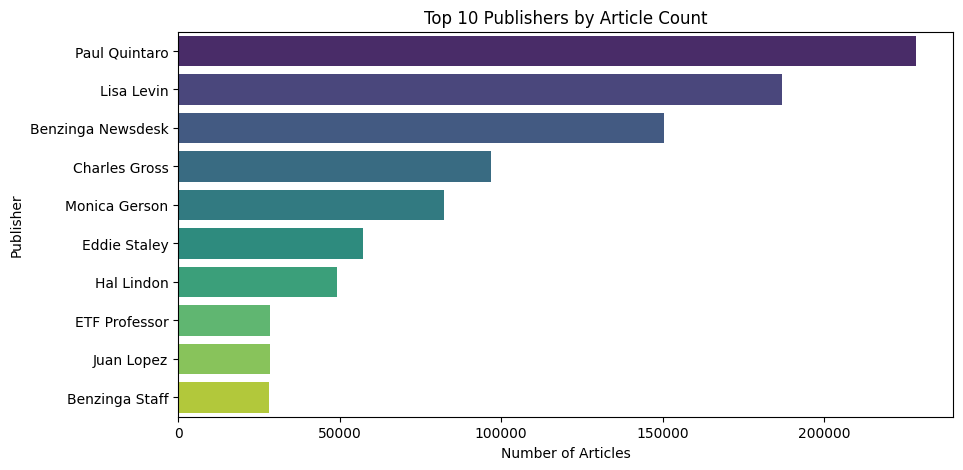

In [9]:
# Most active publishers
top_publishers = df['publisher'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis')
plt.title("Top 10 Publishers by Article Count")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.show()


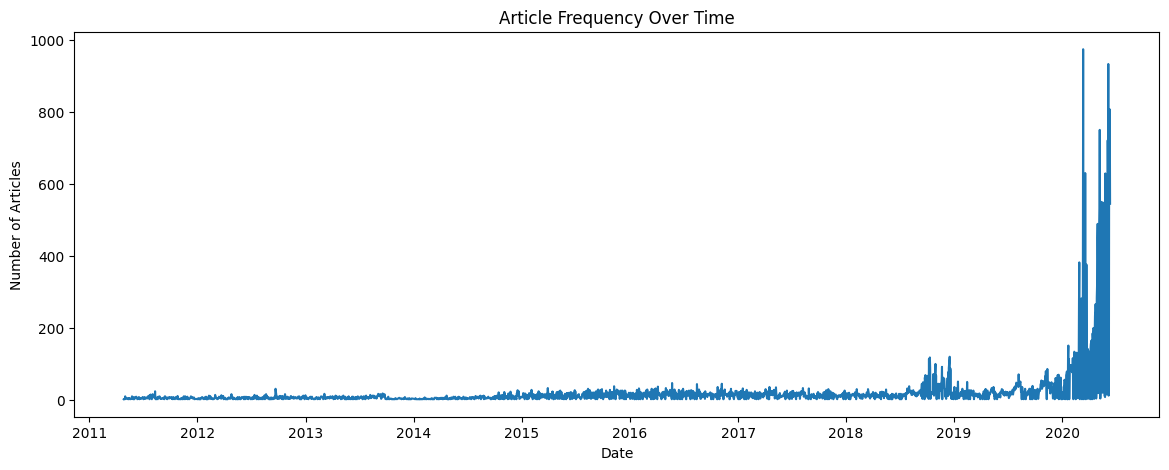

In [10]:
# Articles per day
df['date_only'] = df['date'].dt.date
daily_articles = df['date_only'].value_counts().sort_index()

plt.figure(figsize=(14, 5))
daily_articles.plot()
plt.title("Article Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.show()


C:\Users\chalie.lijalem\AppData\Local\Temp\ipykernel_8972\4284529525.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hourly_dist.index, y=hourly_dist.values, palette='coolwarm')


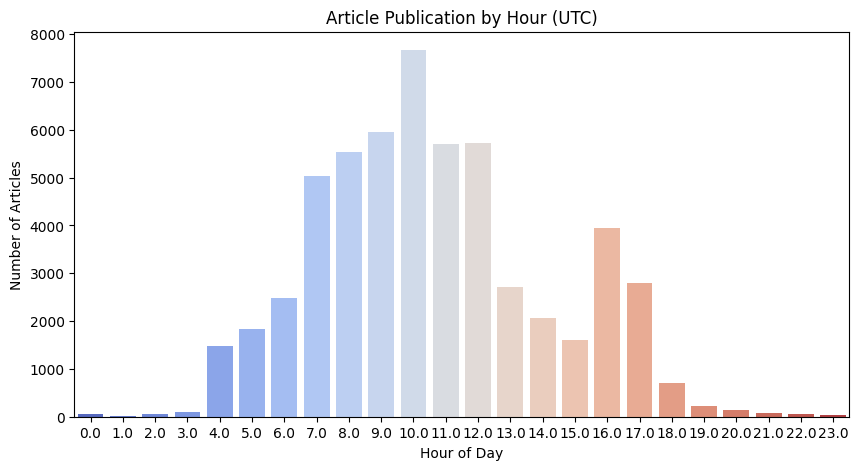

In [11]:

# Hour of publication
df['hour'] = df['date'].dt.hour
hourly_dist = df['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=hourly_dist.index, y=hourly_dist.values, palette='coolwarm')
plt.title("Article Publication by Hour (UTC)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Articles")
plt.show()


In [12]:
# Preprocessing for keyword extraction
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

df['tokens'] = df['headline'].apply(clean_text)

# Most common words
all_tokens = [word for tokens in df['tokens'] for word in tokens]
common_words = Counter(all_tokens).most_common(20)


C:\Users\chalie.lijalem\AppData\Local\Temp\ipykernel_8972\4068884696.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='magma')


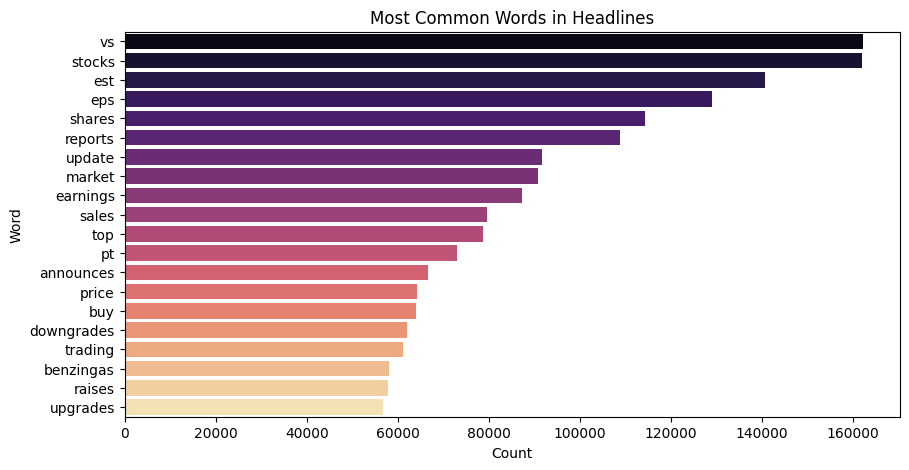

In [13]:

# Barplot of common keywords
words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(counts), y=list(words), palette='magma')
plt.title("Most Common Words in Headlines")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()


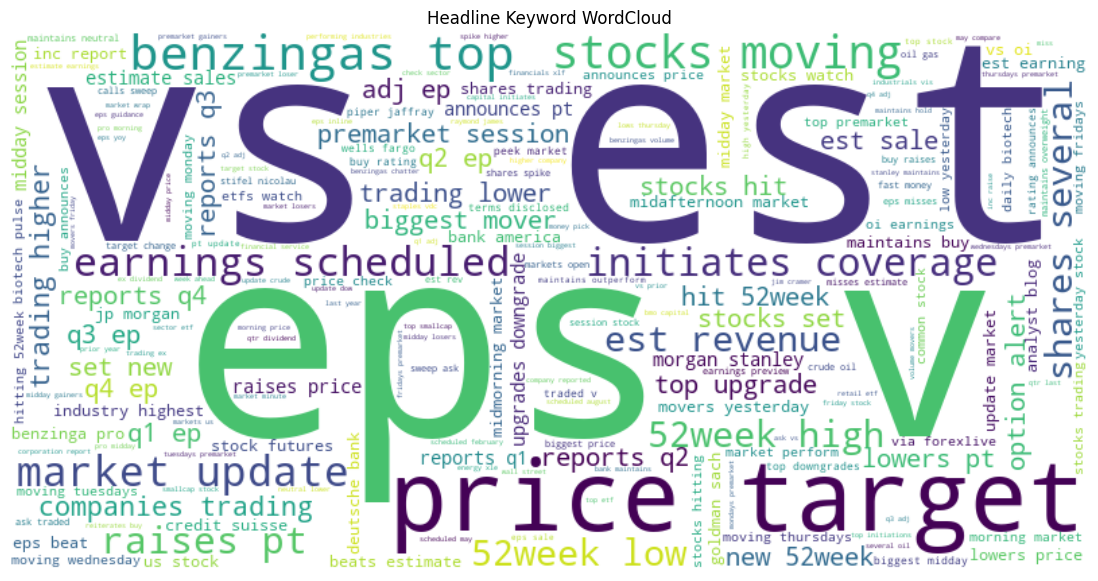

In [14]:

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_tokens))
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Headline Keyword WordCloud")
plt.show()


In [ ]:


# Topic modeling with LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)


In [ ]:

# Display topics
topics = lda_model.print_topics(num_words=5)
for idx, topic in topics:
    print(f"Topic {idx+1}: {topic}")


In [ ]:
# Check if publishers are email addresses
if df['publisher'].str.contains('@').any():
    df['email_domain'] = df['publisher'].str.extract(r'@([\w\.-]+)')
    domain_counts = df['email_domain'].value_counts().head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=domain_counts.values, y=domain_counts.index, palette='Set2')
    plt.title("Top Email Domains from Publishers")
    plt.xlabel("Count")
    plt.ylabel("Email Domain")
    plt.show()
else:
    print("No email domains detected in publishers.")
